In [201]:
# Insert below the path of the developer version of pyBBarolo (= the git repo)
# This way, we can override any other installed version and 
# modify pyBBarolo without the need of reinstalling it every time
import sys
sys.path.insert(0, "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7")

# i just copied the repository

# This should give version 1.3.2dev!
from pyBBarolo import version
print (version)
import pyBBarolo as BB
import pyBBarolo.utils as ut
from pyBBarolo.bayesian import BayesianBBarolo

from dynesty import plotting as dyplot
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import os, subprocess
from astropy.io import fits
BBmain = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/BBarolo"


1.3.2dev


In [ ]:
fitsname = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/ngc2403/ngc2403_s200red.fits"
f = BB.Search(fitsname)


Opening file /Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/ngc2403/ngc2403_s200red.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 



TypeError: expected str, bytes or os.PathLike object, not Search

## Fitting:

In [ ]:
# Name of the FITS file to be fitted
fitsname = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/ngc2403/ngc2403_s200red.fits"
ringfile = '/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/ngc2403/rings_final2.txt'

# f = BB.Search._compute(fitsname) i think this might do something formy problem 

print(f)

# Creating an object for bayesian barolo
f3d = BayesianBBarolo(f)
th  = multiprocessing.cpu_count() #this counts my cpu so that the code can run with all of them

# Initializing rings. All parameters should be given.
# No-fitted parameters will be used for all models, while fitted parameters 
# are actually not even used for initial guesses.
rad=np.arange(60,1200,240)

f3d.init(radii=rad,xpos=25.5,ypos=25.5,vsys=0.0,\
         vrot=120,vdisp=8,vrad=0,z0=0,inc=60,phi=0)
# so basically if all the parameters are free the initial guesses are irrelevant?

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0)
f3d.show_options()

# Default priors are uniform and the default boundaries for the fit are in f3d.bounds. ****
# Here I modify some of them to help convergence for this particular galaxy. --> adapt for every cube!!
#f3d.bounds['vrot']  = [0,250]
#f3d.bounds['vdisp'] = [0,40]
#f3d.bounds['inc']   = [50,70]
#f3d.bounds['phi']   = [20,40]
#f3d.bounds['z0']    = [0,60]
#f3d.bounds['xpos']  = [20,30]
#f3d.bounds['ypos']  = [20,30]
#f3d.bounds['vsys']  = [-20,20]

f3d.bounds['vrot']  = [40,200] 
f3d.bounds['vdisp'] = [0,40]
f3d.bounds['inc']   = [30,70] 
f3d.bounds['phi']   = [100,150]
f3d.bounds['z0']    = [0,15]
f3d.bounds['xpos']  = [70,80]
f3d.bounds['ypos']  = [70,80]
f3d.bounds['vsys']  = [-50,250]

# Running the fit with dynesty.
# To fit a parameter ring-by-ring, just use the parameter name in freepar
# To fit a parameter with a single value, add a '_single' to the parameter name
# In this example, I fit 14 parameters: 4 vrot, 4 vdisp, 1 inc, 1 pa, 1 z0, 1 xpos, 1 ypos and 1 vsys
f3d.compute(threads=th, method='dynesty',freepar=['vrot','vdisp','inc_single','phi_single',
                                      'z0_single','xpos_single','ypos_single','vsys_single'])

AttributeError: 'str' object has no attribute '_check_options'

In [190]:
#here i print the number of indexes and the name of indexes
print(f3d.freepar_idx)
print(f3d.ndim)

#print(dir(f3d))
#print(f3d.params)


#BB.FitsCube(fitsname)
#BB.GalMod(fitsname,)

{'vrot': array([0, 1, 2, 3, 4]), 'vdisp': array([5, 6, 7, 8, 9]), 'inc': array([10]), 'phi': array([11]), 'z0': array([12]), 'xpos': array([13]), 'ypos': array([14]), 'vsys': array([15])}
16


## Model of resulting parameters:

In [191]:
#we calculate the parameters of the initial mock
# Open the FITS file
hdul = fits.open(fitsname)
modname   = 'model_result_barba' 
# Get the header of the primary HDU (Header Data Unit)
fi = hdul[0].header
#these are the sizes
xaxis = fi['NAXIS1']
yaxis = fi['NAXIS2']
zaxis = fi['NAXIS3']
xaxis = fi['NAXIS1']
#here the cdelts
pix1 = fi['CDELT1']
pix2 = fi['CDELT2']
chan = fi['CDELT3']
# the beam
bea = fi['BMAJ']

#creating the shape of the model
sim = ut.SimulatedGalaxyCube(axisDim=[xaxis, yaxis, zaxis],\
                        cdelts=[pix1, pix2, chan],\
                        beam=bea, bunit='JY/BEAM', obj=modname)

a = fits.open(fitsname)[0].header['NAXIS3']
print(a)

62


In [192]:
#we set the parameters
vel  = f3d.params[:5]
disp = f3d.params[5:10]
inn  = np.full(len(rad),f3d.params[10])
phi  = np.full(len(rad),f3d.params[11])
z0d   = np.full(len(rad),f3d.params[12])
xpos = np.full(len(rad),f3d.params[13])
ypos = np.full(len(rad),f3d.params[14])
vsy = np.full(len(rad),f3d.params[15])
dens   = np.full(len(rad),1)
#50*np.exp(-rad/400-100/(0.5*rad+100)) #I will do this for now but ideally this is in the bbarolo?
#noiserms  = 0.08 #again i need to find a way to get this number?

#this part creates the rings file, i guess it is not really necessary buti will leave it for now, since it gives a good visual representation of the parameters

with open("mod_mockrings.txt", 'w') as file:
    file.write("# RAD(arcs)\tVROT(km/s)\tDISP(km/s)\tINC(deg)\tP.A.(deg)tZ0(arcs)\tXPOS(pix)\tYPOS(pix)\tVSYS(km/s)\n")
    # add \tRAD(arcs) after rad kpc and \tZ0(arcs) after tZ0 pc
    # Write the rows
    for rar,vr,di,i,paa,za,x,y,vs in zip(rad,vel,disp,inn,phi,z0d,xpos,ypos,vsy):
        file.write(f'{rar}\t{vr}\t{di}\t{i}\t{paa}\t{za}\t{x}\t{y}\t{vs}\n')
    print("file mod_mockrings.txt created")

    

file mod_mockrings.txt created


In [193]:
BBmain = "/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/BBarolo" #eliminate

# Setting up galaxy parameters (if parameters are not given, they are random!)
sim.define_galaxy(radii=rad,vsys=vsy,vdisp=disp,inc=inn,pa=phi,\
                dens=dens,z0=z0d,vrot=vel,warpinc=False,warppa=False)
print(sim)

# Running BB and creating a model
print (f"Simulating {modname}...",flush=True,end='')
sim.run(exe=BBmain,stdout='null',smooth=True)
print (f"Done! ")



Simulating model_result_barba...Done! 


## Dynesty outputs:

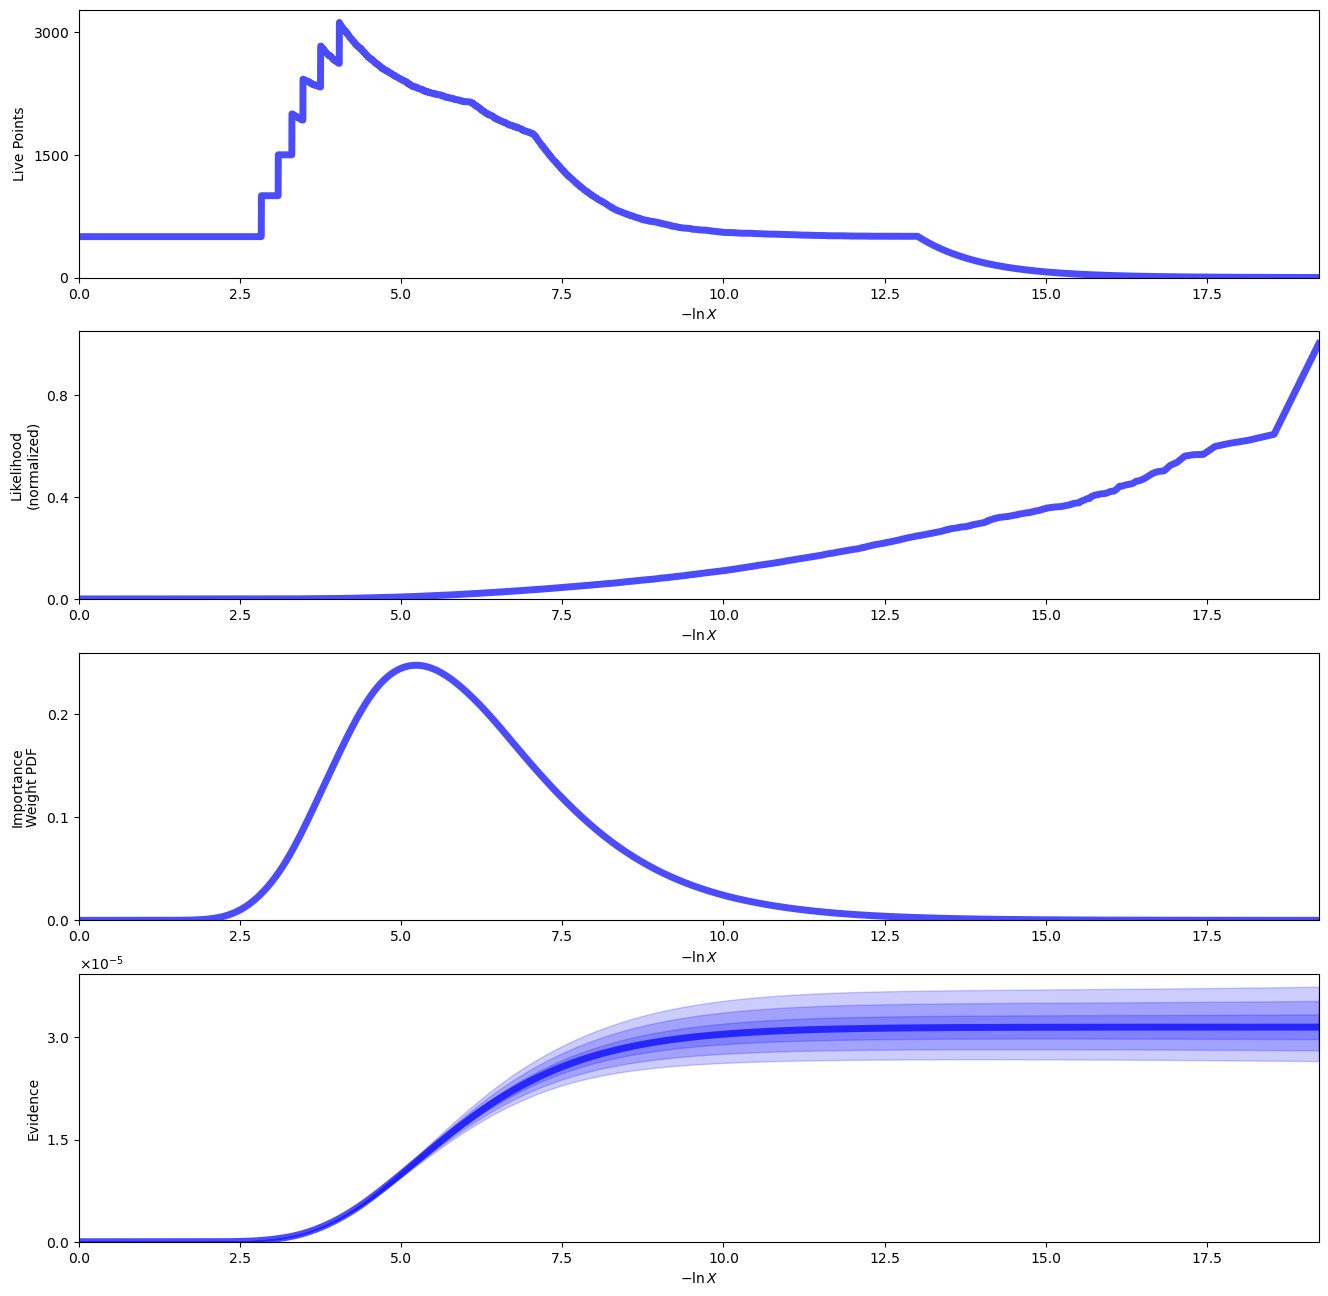

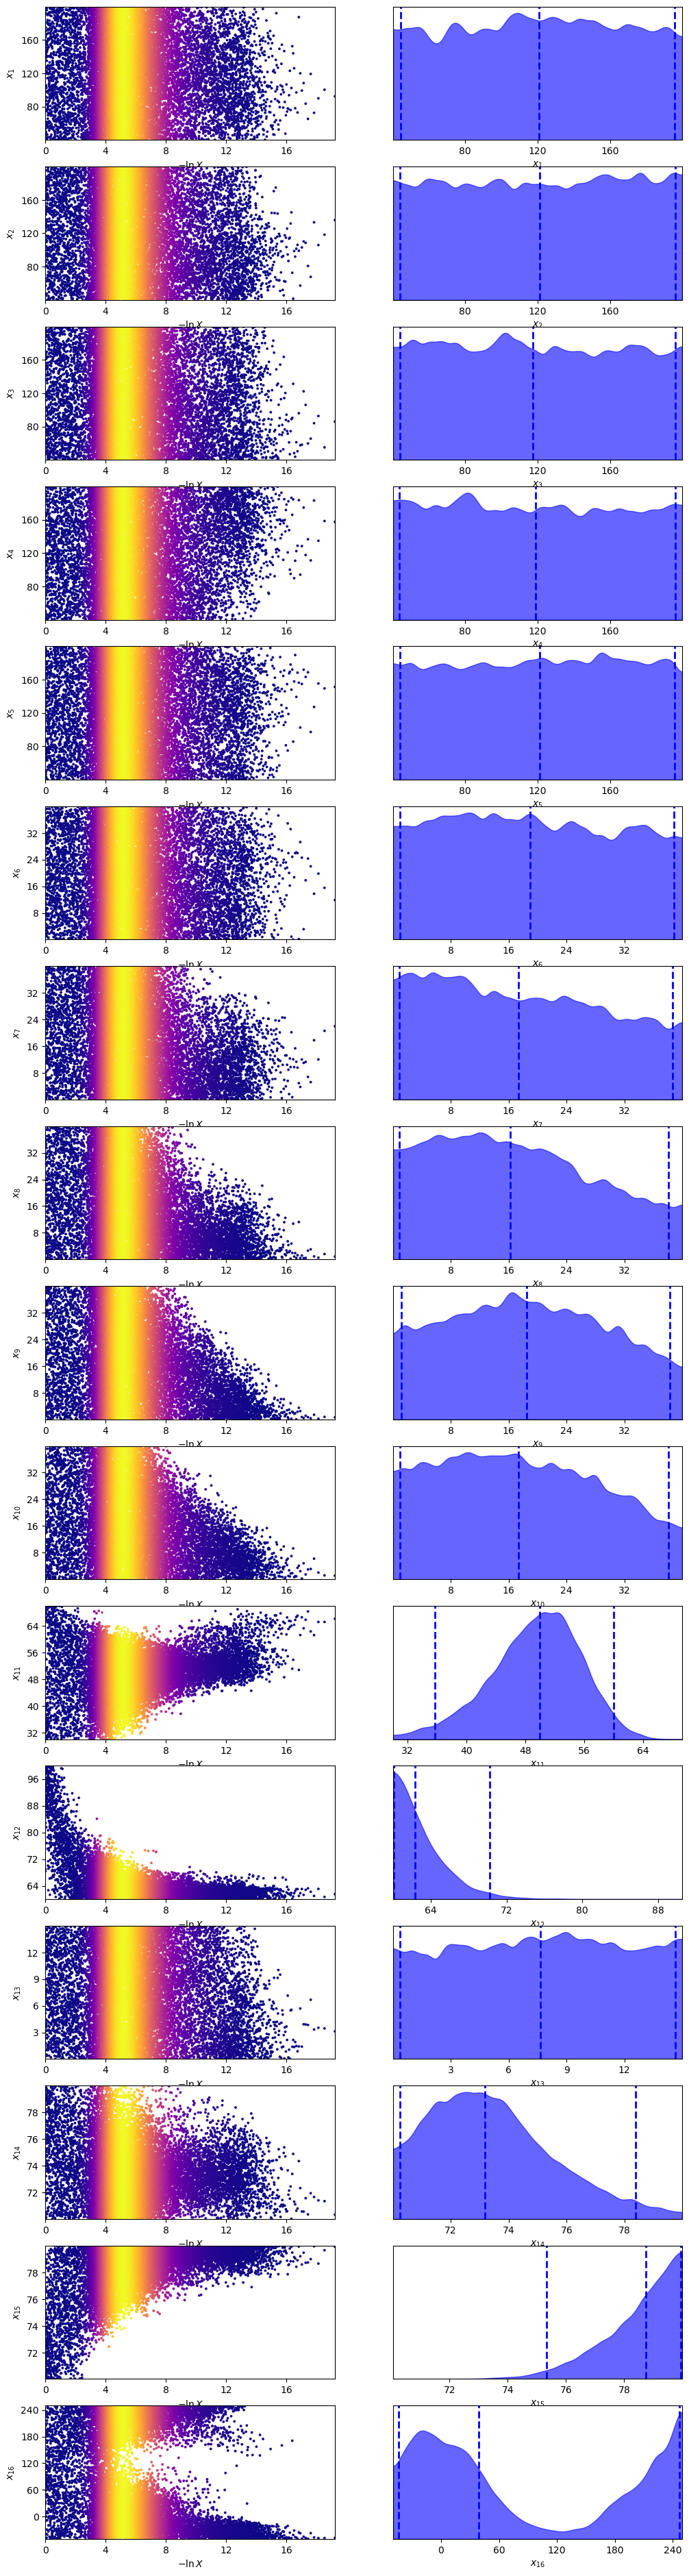

In [194]:
results = f3d.results
#print(results)

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)
# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

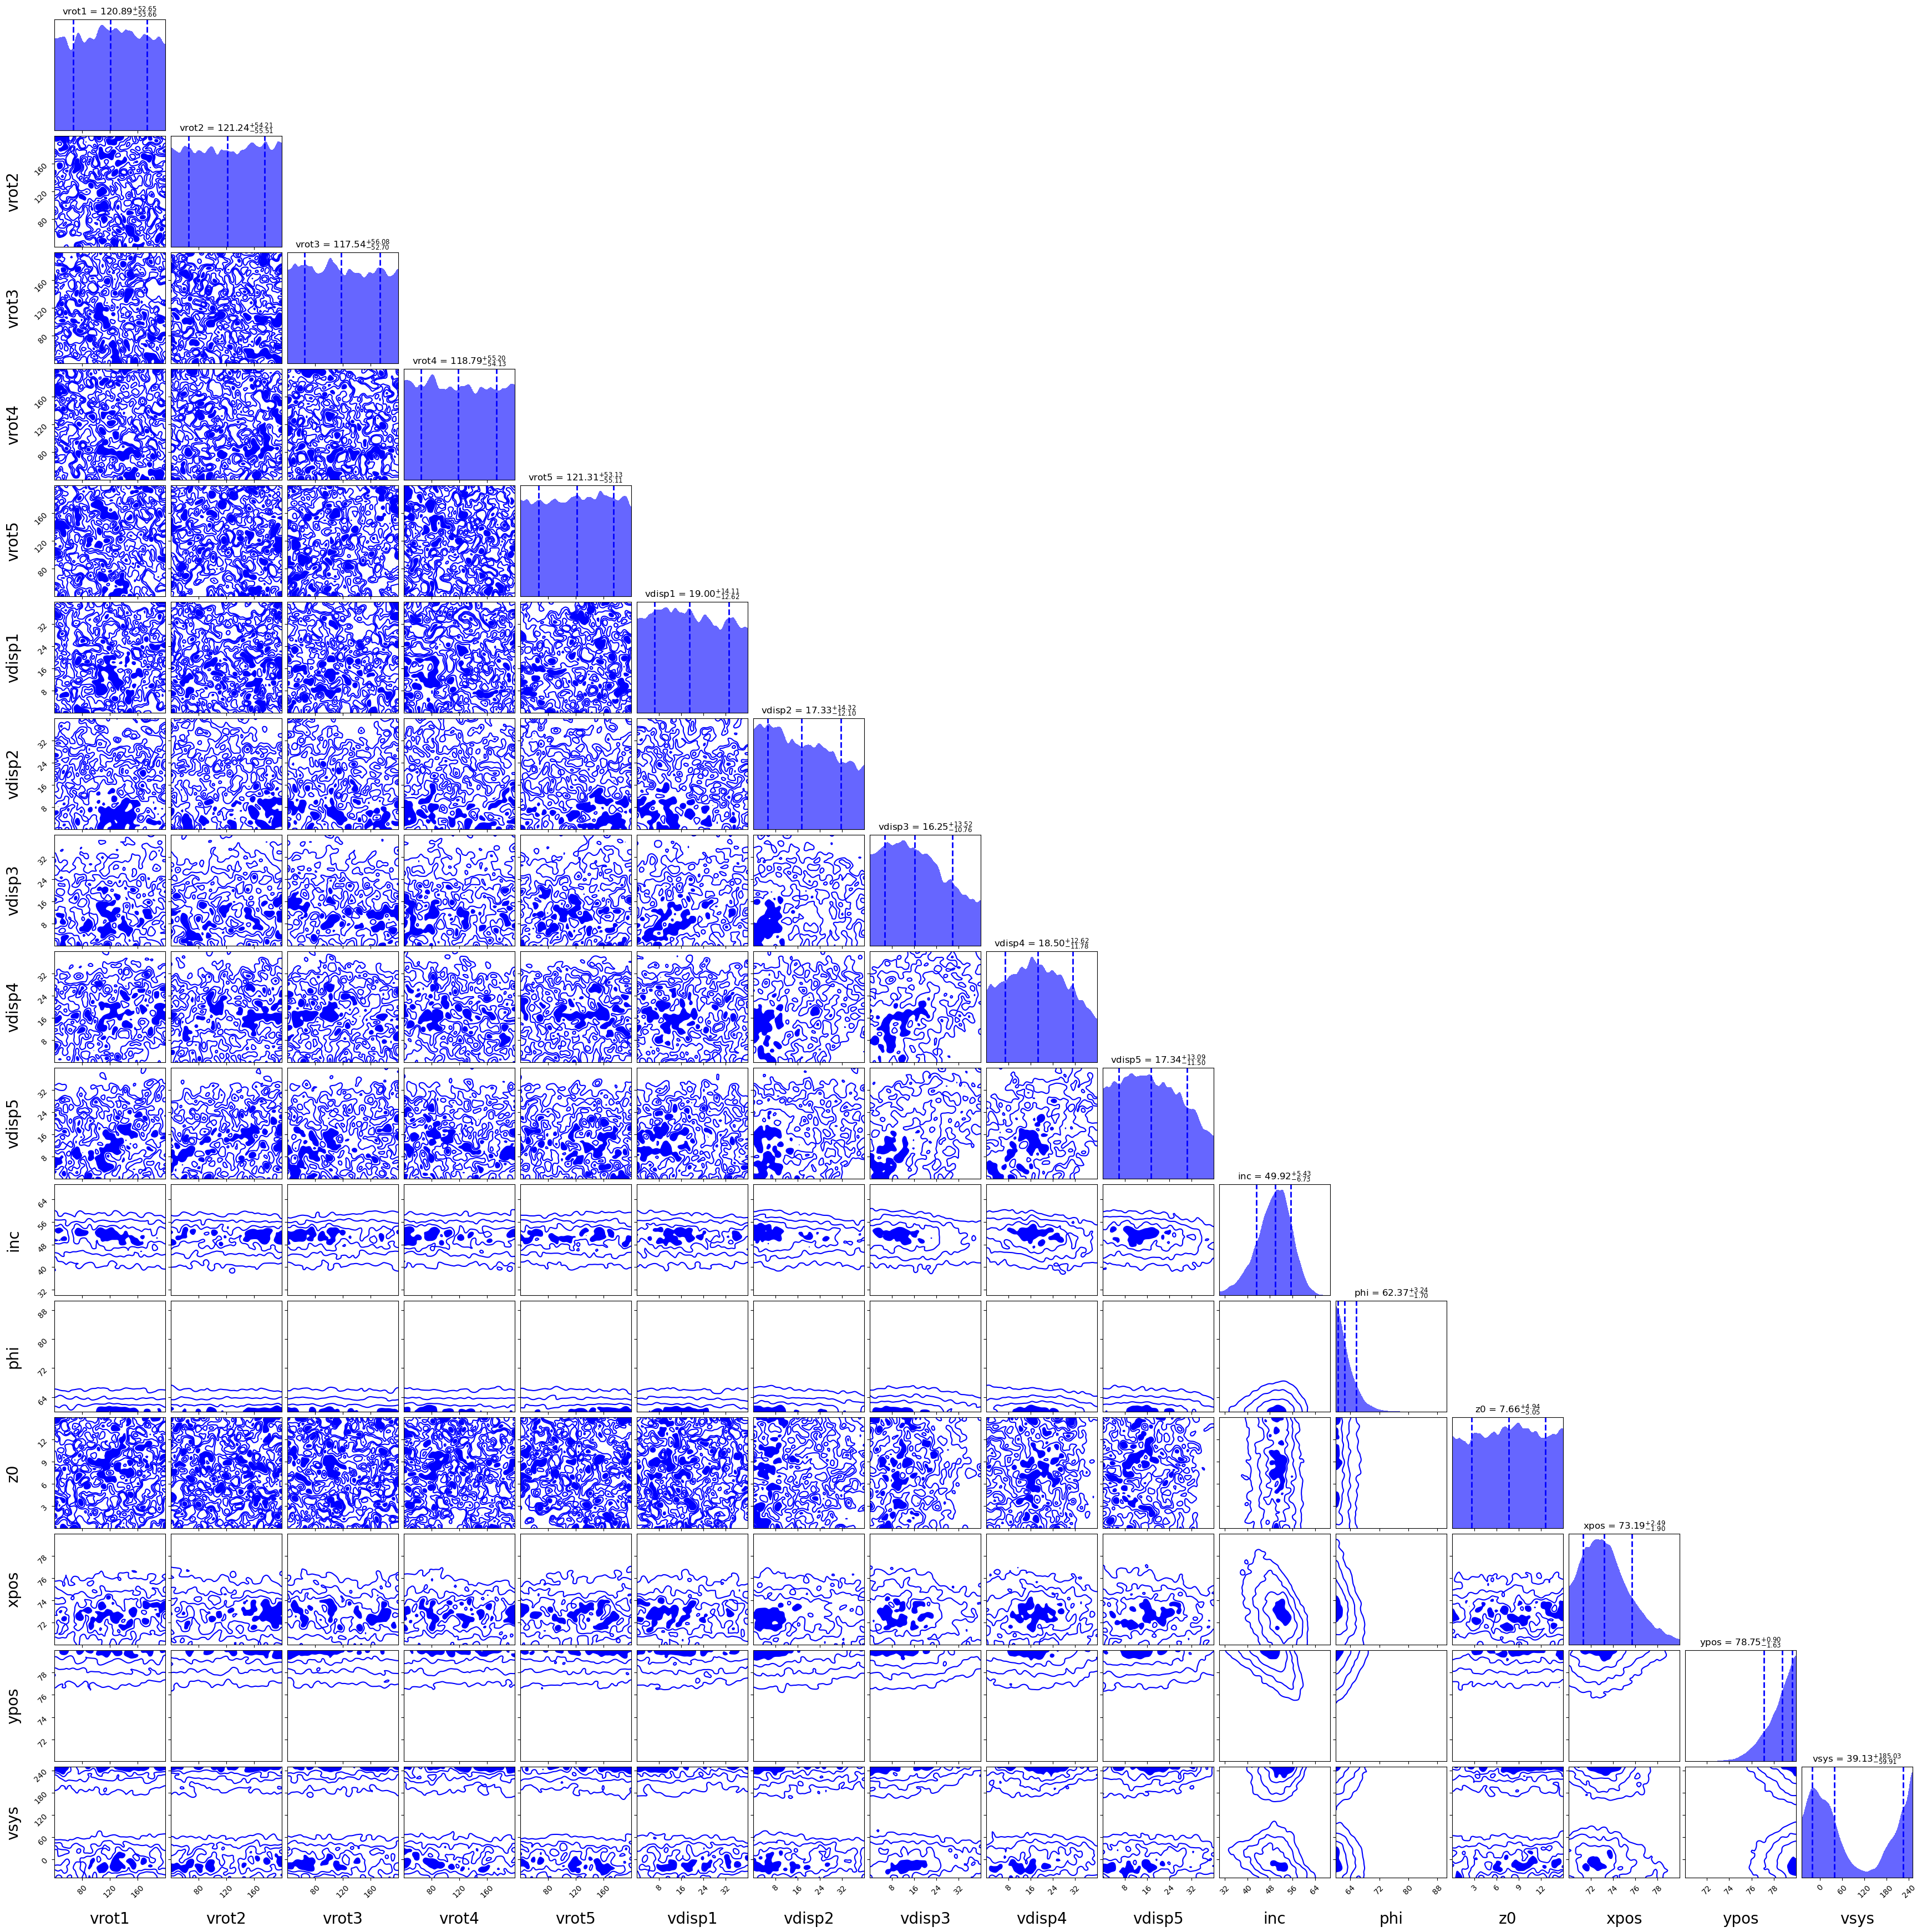

In [195]:
# Plot the 2-D marginalized posteriors.
quantiles = [0.16,0.50,0.84] # are these the contours?
cfig, caxes = dyplot.cornerplot(results,show_titles=True,title_quantiles=quantiles,
                                quantiles=quantiles, color='blue',max_n_ticks=5, labels=f3d.freepar_names, \
                                label_kwargs=dict(fontsize=20))
cfig.savefig('corner.pdf',bbox_inches='tight')

## Errors:

In [196]:
samples = f3d.results.samples
#print(samples) 
weights = np.exp(f3d.results.logwt - f3d.results.logz[-1])
params = np.average(samples, axis=0, weights=weights)
print (params)

labs = f3d.freepar_names
print(labs)
pp, err_up, err_low = np.zeros(shape=(3,len(params)))
for i in range(len(params)):
    mcmc = np.percentile(samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "%10s = %10.3f %+10.3f %+10.3f"%(labs[i],mcmc[1], -q[0], q[1])
    print (txt)
    pp[i] = mcmc[1]
    err_low[i] = q[0]
    err_up[i] = q[1]

[120.48649047 120.85077913 118.85244415 119.0192247  120.72996075
  19.47903258  18.14512248  17.30332812  18.87897017  18.01685168
  49.34959473  63.10124781   7.59410561  73.46632738  78.43561963
  83.58177359]
['vrot1', 'vrot2', 'vrot3', 'vrot4', 'vrot5', 'vdisp1', 'vdisp2', 'vdisp3', 'vdisp4', 'vdisp5', 'inc', 'phi', 'z0', 'xpos', 'ypos', 'vsys']
     vrot1 =    119.304    -52.298    +53.095
     vrot2 =    118.560    -53.671    +55.572
     vrot3 =    115.900    -52.668    +57.173
     vrot4 =    122.023    -55.738    +53.674
     vrot5 =    121.410    -55.642    +52.618
    vdisp1 =     18.868    -12.684    +14.108
    vdisp2 =     16.450    -11.473    +14.695
    vdisp3 =     14.998    -10.253    +14.488
    vdisp4 =     16.807    -11.791    +13.864
    vdisp5 =     15.822    -10.774    +14.204
       inc =     50.423     -7.364     +5.867
       phi =     62.620     -1.900     +4.403
        z0 =      7.346     -5.010     +5.152
      xpos =     73.288     -1.966     +2.609
   

['RAD(Kpc)', 'RAD(arcs)', 'VROT(km/s)', 'DISP(km/s)', 'INC(deg)', 'P.A.(deg)', 'Z0(pc)', 'Z0(arcs)', 'SIG(E20)', 'XPOS(pix)', 'YPOS(pix)', 'VSYS(km/s)', 'VRAD(km/s)']
dict_keys(['radii', 'xpos', 'ypos', 'vsys', 'vrot', 'vdisp', 'vrad', 'vvert', 'dvdz', 'zcyl', 'dens', 'z0', 'inc', 'phi'])
[  60.  300.  540.  780. 1020.]


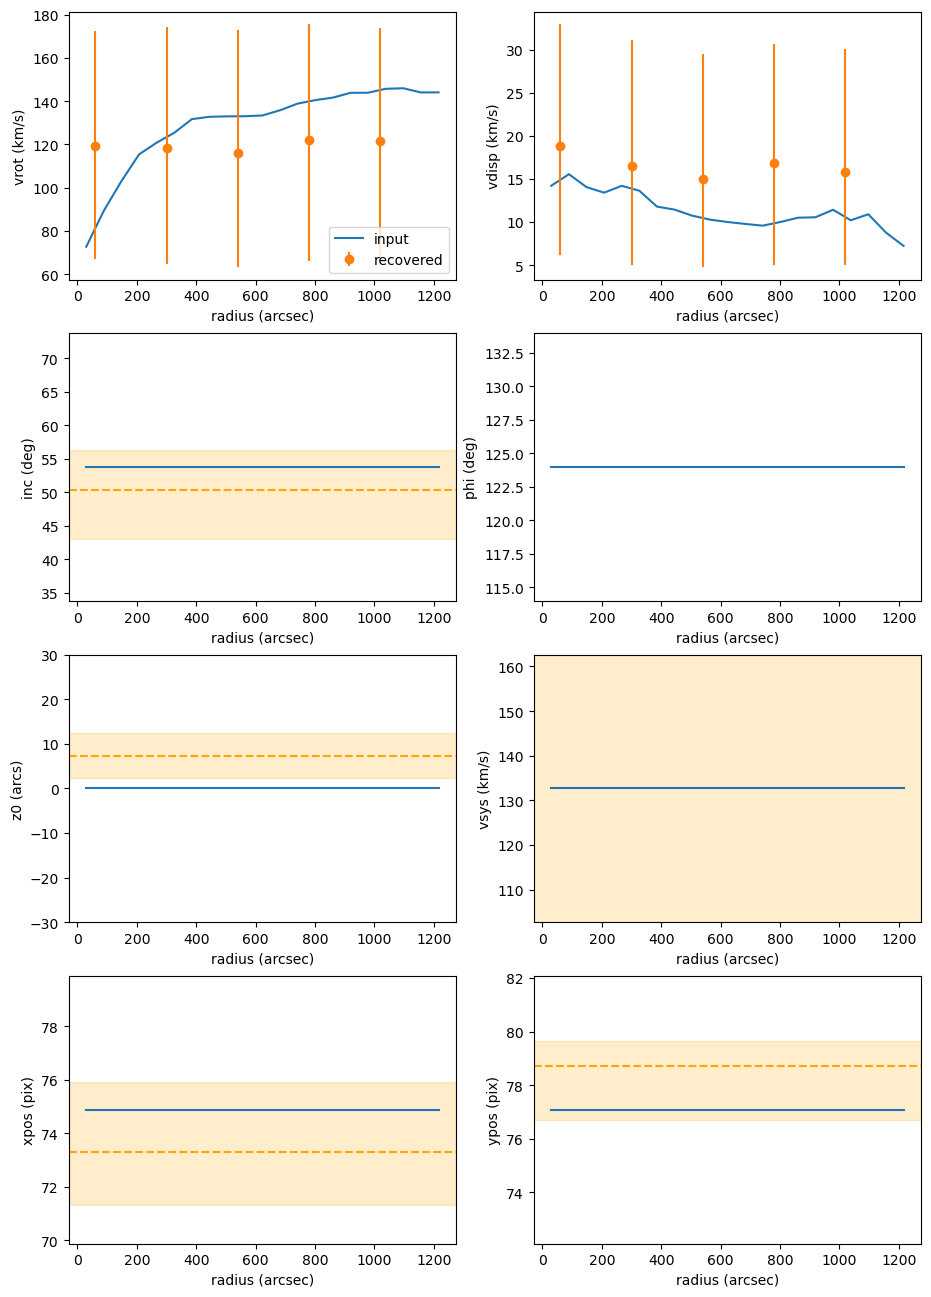

In [197]:
# Compare with "real" input parameters, this is now comparing with the output of bbarolo (normal)
#ringfile = '/Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/SGP38326/rings_final1.txt'
t = Table.read(ringfile,format='ascii')
print(t.colnames)


fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))
ax = np.ravel(ax)
for a in ax:
    a.set_xlabel("radius (arcsec)")
print(f3d._inri.r.keys())
rad_mc = f3d._inri.r['radii']
print(rad_mc)
idx = f3d.freepar_idx['vrot']
ax[0].plot(t['RAD(arcs)'],t['VROT(km/s)'],label='input')
ax[0].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]],label='recovered')
ax[0].set_ylabel("vrot (km/s)")
ax[0].legend(loc='lower right')

idx = f3d.freepar_idx['vdisp']
ax[1].plot(t['RAD(arcs)'],t['DISP(km/s)'])
ax[1].errorbar(rad_mc,pp[idx],fmt='o',yerr=[err_low[idx],err_up[idx]])
ax[1].set_ylabel("vdisp (km/s)")

idx = f3d.freepar_idx['inc']
ax[2].plot(t['RAD(arcs)'],t['INC(deg)'])
ax[2].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[2].axhline(pp[idx][0],ls='--',color='orange')
ax[2].set_ylabel("inc (deg)")
ax[2].set_ylim(t['INC(deg)'][0]-20,t['INC(deg)'][0]+20)

idx = f3d.freepar_idx['phi']
ax[3].plot(t['RAD(arcs)'],t['P.A.(deg)'])
ax[3].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[3].axhline(pp[idx][0],ls='--',color='orange')
ax[3].set_ylabel("phi (deg)")
ax[3].set_ylim(t['P.A.(deg)'][0]-10,t['P.A.(deg)'][0]+10)

idx = f3d.freepar_idx['z0']
ax[4].plot(t['RAD(arcs)'],t['Z0(arcs)'])
ax[4].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[4].axhline(pp[idx][0],ls='--',color='orange')
ax[4].set_ylabel("z0 (arcs)")
ax[4].set_ylim(t['Z0(arcs)'][0]-30,t['Z0(arcs)'][0]+30)

idx = f3d.freepar_idx['vsys']
ax[5].plot(t['RAD(arcs)'],t['VSYS(km/s)'])
ax[5].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[5].axhline(pp[idx][0],ls='--',color='orange')
ax[5].set_ylabel("vsys (km/s)")
ax[5].set_ylim(t['VSYS(km/s)'][0]-30,t['VSYS(km/s)'][0]+30)

idx = f3d.freepar_idx['xpos']
ax[6].plot(t['RAD(arcs)'],t['XPOS(pix)'])
ax[6].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[6].axhline(pp[idx][0],ls='--',color='orange')
ax[6].set_ylabel("xpos (pix)")
ax[6].set_ylim(t['XPOS(pix)'][0]-5,t['XPOS(pix)'][0]+5)

idx = f3d.freepar_idx['ypos']
ax[7].plot(t['RAD(arcs)'],t['YPOS(pix)'])
ax[7].axhspan(pp[idx][0]-err_low[idx][0],pp[idx][0]+err_up[idx][0],alpha=0.2,color='orange')
ax[7].axhline(pp[idx][0],ls='--',color='orange')
ax[7].set_ylabel("ypos (pix)")
ax[7].set_ylim(t['YPOS(pix)'][0]-5,t['YPOS(pix)'][0]+5)

fig.savefig('parameters.pdf',bbox_inches='tight')

In [198]:
# If one wants to change the likelihood and/or prior, can just write a class that inherits
# from BayesianBBarolo and redefine the log_likelihood and prior_transform functions

class CustomBayesianBBarolo(BayesianBBarolo):
    def log_likelihood(self, theta):
        ...

    def prior_transform(self, u):
        ...

custom_f3d = CustomBayesianBBarolo(fitsname)



Opening file /Users/blanca/Documents/TESIS/software/Bbarolo-1.7/output/ngc2403/ngc2403_s200red.fits
Reading 75 x 75 x 62 pixels FITS file (1.3 MB)... Done. 



In [199]:
#inp = FitsCube(fitsname)
#mod = libBB.Galfit_new_par(inp._cube,inri._rings,opts._params)

# SOME THINGS TO DO 

- Fix parallel execution
- Play with dynesty samplers and parameters (these can be passed to compute() by dynesty_kwargs)
- Decide if residuals are calculated by BB or in python (more flexible)
- Need to implement output model generation + usual plots (various maps, pvs, etc...)
- Easily expandable to fit also other parameters (DENS, VVERT, DVDZ, ZCYL)
- Easily expandable to support functional forms for parameters
- There is a memory leak somewhere, memory usage grows when it should not (not a big problem though).